# indyindians Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [4]:
lkupclientid = 21 # indyindians

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5454 entries, 0 to 5453
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              5454 non-null   int64  
 1   dimCustomerMasterId       5454 non-null   int64  
 2   customerNumber            256 non-null    object 
 3   year                      5454 non-null   object 
 4   productGrouping           5454 non-null   object 
 5   totalSpent                5454 non-null   float64
 6   recentDate                5454 non-null   object 
 7   attendancePercent         5454 non-null   float64
 8   renewedBeforeDays         5454 non-null   int64  
 9   isBuyer                   5454 non-null   object 
 10  source_tenure             5454 non-null   int64  
 11  tenure                    5454 non-null   int64  
 12  distToVenue               5454 non-null   float64
 13  totalGames                5454 non-null   int64  
 14  recency 

### Let's drop the features that have lots of null values:

In [5]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'customerNumber',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5454 entries, 0 to 5453
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          5454 non-null   int64  
 1   dimCustomerMasterId   5454 non-null   int64  
 2   year                  5454 non-null   object 
 3   productGrouping       5454 non-null   object 
 4   totalSpent            5454 non-null   float64
 5   recentDate            5454 non-null   object 
 6   attendancePercent     5454 non-null   float64
 7   renewedBeforeDays     5454 non-null   int64  
 8   isBuyer               5454 non-null   object 
 9   source_tenure         5454 non-null   int64  
 10  tenure                5454 non-null   int64  
 11  distToVenue           5454 non-null   float64
 12  totalGames            5454 non-null   int64  
 13  recency               5454 non-null   int64  
 14  missed_games_1        5454 non-null   int64  
 15  missed_games_2       

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [6]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (4909, 46)
Unseen Data For Predictions: (545, 46)
Data for Modeling (A Class): (4909, 46)
Unseen Data For Predictions: (545, 46)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [7]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(5454, 17)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [8]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5454 entries, 0 to 5453
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   totalSpent           5454 non-null   float64
 1   renewedBeforeDays    5454 non-null   int64  
 2   source_tenure        5454 non-null   int64  
 3   tenure               5454 non-null   int64  
 4   totalGames           5454 non-null   int64  
 5   missed_games_1       5454 non-null   int64  
 6   missed_games_2       5454 non-null   int64  
 7   missed_games_over_2  5454 non-null   int64  
 8   isNextYear_Buyer     5454 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 383.6 KB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [9]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,totalSpent,renewedBeforeDays,source_tenure,tenure,totalGames,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer
totalSpent,1.00,0.23,0.02,-0.00,0.51,0.18,0.22,0.39,0.11
renewedBeforeDays,0.23,1.00,-0.09,-0.10,0.35,0.23,0.27,0.39,0.46
source_tenure,0.02,-0.09,1.00,0.96,-0.01,-0.02,-0.03,-0.04,-0.15
tenure,-0.00,-0.10,0.96,1.00,-0.02,-0.03,-0.05,-0.07,-0.15
totalGames,0.51,0.35,-0.01,-0.02,1.00,0.62,0.57,0.64,0.26
missed_games_1,0.18,0.23,-0.02,-0.03,0.62,1.00,0.52,0.34,0.16
missed_games_2,0.22,0.27,-0.03,-0.05,0.57,0.52,1.00,0.44,0.17
missed_games_over_2,0.39,0.39,-0.04,-0.07,0.64,0.34,0.44,1.00,0.23
isNextYear_Buyer,0.11,0.46,-0.15,-0.15,0.26,0.16,0.17,0.23,1.00


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [10]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (4363, 9)
Unseen Data For Predictions: (1091, 9)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [11]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "totalSpent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,6380
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(4363, 9)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(5,
 'clf-default-name',
 [],
 {'lr': <pycaret.containers.models.classification.LogisticRegressionClassifierContainer at 0x7fa79db5b450>,
  'knn': <pycaret.containers.models.classification.KNeighborsClassifierContainer at 0x7fa79db5b550>,
  'nb': <pycaret.containers.models.classification.GaussianNBClassifierContainer at 0x7fa79db5b690>,
  'dt': <pycaret.containers.models.classification.DecisionTreeClassifierContainer at 0x7fa79db5b750>,
  'svm': <pycaret.containers.models.classification.SGDClassifierContainer at 0x7fa79db5b9d0>,
  'rbfsvm': <pycaret.containers.models.classification.SVCClassifierContainer at 0x7fa79db5bd10>,
  'gpc': <pycaret.containers.models.classification.GaussianProcessClassifierContainer at 0x7fa79db5be50>,
  'mlp': <pycaret.containers.models.classification.MLPClassifierContainer at 0x7fa79db5bf10>,
  'ridge': <pycaret.containers.models.classification.RidgeClassifierContainer at 0x7fa79731e1d0>,
  'rf': <pycaret.containers.models.classification.RandomForestClassifi

In [12]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
5,Light Gradient Boosting Machine,0.7891,0.8621,0.7690,0.7656,0.7670,0.5744,0.5748,0.0320
2,Gradient Boosting Classifier,0.7885,0.8663,0.7627,0.7675,0.7648,0.5727,0.5732,0.0880
7,Random Forest Classifier,0.7819,0.8590,0.7525,0.7621,0.7566,0.5592,0.5600,0.2130
9,Extreme Gradient Boosting,0.7799,0.8541,0.7582,0.7555,0.7568,0.5559,0.5560,0.3470
0,Ada Boost Classifier,0.7788,0.8577,0.7398,0.7630,0.7505,0.5520,0.5530,0.0440
3,Extra Trees Classifier,0.7751,0.8479,0.7494,0.7524,0.7505,0.5457,0.5462,0.2170
8,NGBClassifier,0.7748,0.8575,0.7271,0.7638,0.7441,0.5433,0.5448,1.1350
4,K Neighbors Classifier,0.7559,0.8259,0.7399,0.7253,0.7320,0.5079,0.5086,0.0480
6,Logistic Regression,0.7375,0.7754,0.6205,0.7558,0.6808,0.4616,0.4687,0.0310
1,Decision Tree Classifier,0.7112,0.7071,0.6719,0.6836,0.6772,0.4159,0.4164,0.0080


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [13]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7650,0.8414,0.7342,0.7436,0.7389,0.5253,0.5254
1,0.8023,0.8767,0.7595,0.7947,0.7767,0.5995,0.6000
2,0.8052,0.8733,0.7911,0.7812,0.7862,0.6072,0.6073
3,0.7822,0.8500,0.7405,0.7697,0.7548,0.5591,0.5594
4,0.7908,0.8776,0.8165,0.7457,0.7795,0.5813,0.5835
5,0.7851,0.8574,0.7911,0.7485,0.7692,0.5684,0.5692
6,0.7708,0.8572,0.7516,0.7421,0.7468,0.5374,0.5375
7,0.8080,0.8751,0.7707,0.7961,0.7832,0.6110,0.6113
8,0.7736,0.8351,0.7452,0.7500,0.7476,0.5424,0.5424
9,0.8080,0.8767,0.7898,0.7848,0.7873,0.6124,0.6124


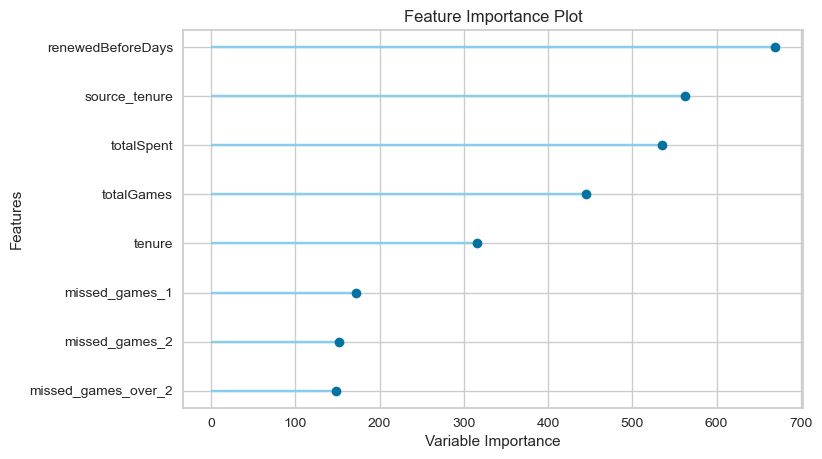

In [14]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?